# Player Rebounds

Determining the density of rebounds per team and potential offensive opportunities. 

In [75]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
%matplotlib inline

from pandas import DataFrame
from py_ball import playbyplay
from typing import Union

In [73]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Introduction

Basketball's flashiest plays can often come out of a fast break in transition. In this project, we created a tool that helps teams and coaches visualize how successful a team is in these scenarios, following a defensive rebound. By mapping out how high danger these rebounds are based on quick shots taken after the rebound, players can see how, where, and when to quickly take advantage of regaining possession.

## Dataframe

By collecting and sorting relevant data - types of shots and teams, we can analyze the rebounds and the rebounds that lead to a transition as well as the frequency of these events. 

In [4]:
# py_ball variables

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

# EVENTMSGTYPE code from pbp data with corresponding eventType data
event_dict = {
    1: 'SHOT',
    2: 'SHOT',
    3: 'FT',
    4: 'REB',
    5: 'TO',
    6: 'FOUL',
    7: 'VIO',
    8: 'SUB',
    9: 'TMO',
    10: 'JB'
}

# the EVENTMSGCODE for the event, along with the danger level it corresponds to
danger_type = {
    0: 3,
    1: 5,
    2: 4
}

In [28]:
def load_game(game_id: str) -> DataFrame:
    """a function that creates a merged dataframe of relevant data from events, tracking, and pbp for a given game

    Args:
        game_id (str): the id of the game being called

    Returns:
        DataFrame: a dataframe merging the events, tracking, and pbp from the corresponding game
    """
    # this reads the events, tracking, and play dataframes separately
    df_e = pd.read_json(f"./games/{game_id}/{game_id}_events.jsonl", lines=True)
    df_t = pd.read_json(f"./games/{game_id}/{game_id}_tracking.jsonl", lines=True).drop_duplicates(subset=['gameClock','period'])
    plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)
    play_df = pd.DataFrame(plays.data['PlayByPlay'])
    play_df = play_df.filter(items=['EVENTNUM', 'EVENTMSGTYPE', 'GAME_ID', 'PLAYER1_TEAM_NICKNAME'])
    play_df['event'] = play_df['EVENTMSGTYPE'].map(event_dict)

    # merges events and tracking based on gameClock and period
    e_and_t = df_e.merge(df_t, how='inner', on=['gameClock', 'period']).filter\
                    (items=['gameId', 'eventType','shotClock_x','gameClock','period','ball', 'pbpId'])

    # merges events and tracking with the pbp data
    final_df = e_and_t.merge(play_df, left_on=['eventType','pbpId'], right_on=['event','EVENTNUM'], how='inner').\
                    rename(columns={'PLAYER1_TEAM_NICKNAME': 'team'}).drop(columns=['event', 'pbpId'])
       
    return final_df

def mult_games(games: list) -> DataFrame:
    """loads multiple games

    Args:
        games (list): the list of game ids

    Returns:
        DataFrame: the dataframe (following the format from load_game) with data from the games in the list
    """
    df = load_game(games[0])
    for i in games[1:]:
        df = pd.concat(objs=[df, load_game(i)], ignore_index=True)

    return df

Specifying teams and offensive and densive plays.

* queries for offense and defence for each team based on who has possession of the ball given the court side
* queries for the team
* queries for the event type - specifically looking at rebounds, and if they lead to shots or no shots in transition

In [7]:
def game_evs(df: DataFrame, events: Union[list, int], team: str='none', oord: str='none') -> DataFrame:
    """filters the dataframe based on the event(s)

    Args:
        df (DataFrame): the game(s) data
        events (Union[list, int]): either a list of the event codes or an event code
        team (str, optional): the team that performed the event. Defaults to 'none'.
        oord (str, optional): if the event is a rebound, whether it's offensive('o') or defensive('d'). Defaults to 'none'.

    Returns:
        DataFrame: a dataframe with the games filtered on event
    """

    new_df = df
    new_df['rebmatch'] = new_df.team.eq(new_df.team.shift())

    # queries by offensive or defensive, if given
    if oord == 'o':
        new_df = new_df.query(f"rebmatch == True")
    if oord == 'd':
        new_df = new_df.query(f"rebmatch == False")

    # queries by event
    if type(events) == list:
        string = f"EVENTMSGTYPE == {events[0]}"
        for i in events:
            string = f"{string} or EVENTMSGTYPE == {i}"
        new_df = new_df.query(string)
    else:
        new_df = new_df.query(f"EVENTMSGTYPE == {events}")

    # queries by team, if given
    if team != 'none':
        new_df = new_df.query(f"team == '{team}'") 

    # separates the ball
    new_coords = pd.DataFrame(new_df.pop('ball').tolist(), index=new_df.index, columns = ['x','y','z'])
    combined = pd.concat([new_df, new_coords.reindex(new_df.index)], axis=1).dropna().drop(columns=['rebmatch', 'z'])

    return combined.drop(columns=['gameId'])

## High Danger Zones
Given the limited data, we assumed all shots made 10 seconds after a defensive rebounds are considered shots made in transition. Mapping which defensive rebounds lead to a shot or an attempted shot 10 seconds after will determine the danger of each rebound and analyze potential transitions made. 

In [8]:
def in_ranges(time: float, period: int, game: int, team: str, ranges: list) -> Union[bool, list]:
    """determines whether or not a given shot was taken in a 10 second part of the game

    Args:
        time (float): the time on the game clock when the shot happened
        period (int): the period that it happened in
        game (int): the game it was in
        team (str): the team that made the shot
        ranges (list): a list of potential 10 second parts

    Returns:
        Union[bool, list]: the first element of the list says if the shot happened while the second returns the 
                           rebound time it was attached to if it happened, and False if it didn't
    """
    time_int = int(time * 100)
    for i in ranges:
        if time_int >= i[0] and time_int <= i[1] and period == i[2] and game == i[3] and team == i[4]:
            return [True, i[1]]
    
    return [False, False]


def high_danger(rebs: DataFrame, shots: DataFrame) -> DataFrame:
    """_summary_

    Args:
        rebs (DataFrame): the dataframe of rebounds
        shots (DataFrame): the dataframe of shots

    Returns:
        DataFrame: the dataframe of rebounds in addition to columns with the shot that came in transition if there was one, 
                   along with danger level
    """

    # creates the list of 10-sec ranges post defensive rebound
    reb_ranges = []
    n = rebs.gameClock.values.tolist()
    p = rebs.period.values.tolist()
    g = rebs.GAME_ID.values.tolist()
    t = rebs.team.values.tolist()
    for i in range(len(n)- 1):
        num = n[i]
        reb_ranges.append([int(num * 100) - 1000, int(num * 100), p[i], int(g[i]), t[i]])
    
    # checks if the shots are in range
    shots['inRange'] = shots.apply(lambda x: in_ranges(x.gameClock, x.period, int(x.GAME_ID), x.team, reb_ranges), axis=1)
    range_pop = pd.DataFrame(shots.pop('inRange').tolist(), index=shots.index, columns=['bool', 'time'])
    shots_new = pd.concat([shots, range_pop.reindex(shots.index)], axis=1).\
                drop(columns=['EVENTNUM', 'shotClock_x', 'eventType']).\
                rename(columns={'EVENTMSGTYPE': 'shotType', 'x': 'shot_x', 'y': 'shot_y'})
    
    rebs.loc[:, 'int_time'] = (rebs['gameClock'] * 100).astype(int)

    # combines the rebounds with their respective shots, if a shot exists
    together = pd.merge(rebs, shots_new, left_on=['int_time', 'period', 'GAME_ID', 'team'], right_on=['time', 'period', 'GAME_ID', 'team'], how='left')
    together['shotType'] = together['shotType'].fillna(0).astype(int)
    together['danger'] = together['shotType'].map(danger_type)
    together = together.drop(columns=['shotClock_x', 'EVENTMSGTYPE', 'int_time', 'shotType', 'bool', 'time'])

    return together.drop_duplicates(subset='gameClock_x', keep='first')

def get_dangers(games: list, team: str):
    game_df = mult_games(games)

    rebound_df = game_evs(game_df, 4, team, 'd').query('x >= -47 and x <= 47')
    rebound_l = rebound_df.query('x <= 0')
    rebound_r = rebound_df.query('x > 0')

    shot_df = game_evs(game_df, [1, 2], team)

    danger = high_danger(rebound_df, shot_df)
    danger_l = high_danger(rebound_l, shot_df)
    danger_r = high_danger(rebound_r, shot_df)

    return danger, danger_l, danger_r

## Visualization
Displaying the density of rebounds, and mapping the shots that followed for each team in each game. 

In [55]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl

game_ids = ['0042100301', '0042100302', '0042100303', '0042100304', '0042100305', '0042100306', '0042100307',\
            '0042100311', '0042100312', '0042100313', '0042100314', '0042100315', '0042100401', '0042100402',\
            '0042100403', '0042100404', '0042100405', '0042100406']

## bounds of court
court_x = 47
court_y = 25

def get_coords(lst):
    x, y = [], []

    for point in lst: 
        x.append(point[0]) # add x coords from lst
        y.append(point[1]) # add y coords from lst
    return x, y


def label_points(game, labels):
    x, y = get_coords(game)

    ## display danger levels of points to the net
    for i in range(len(x)):
        plt.text(x[i], y[i], labels[i], size = 5)
    

def get_colours(team):
    ## custom colourmaps
    if team == 'Heat':
        colours = mpl.colors.ListedColormap(['#f9a01b', '#98002e', '#000000'])
    elif team == 'Celtics':
        colours =  mpl.colors.ListedColormap(['#bc9a5c', '#008853', '#000000'])
    elif team == 'Warriors':
        colours = mpl.colors.ListedColormap(['#ffc72c', '#006bb6', '#0b385f'])
    elif team == 'Mavericks':
        colours = mpl.colors.ListedColormap(['#c4ced4', '#1061ac', '#000000'])
    return colours


def plot_init(games, team):
    dreb_x, dreb_y = get_coords(games.filter(['x', 'y']).values.tolist()) # x,y coords of def rebs
    danger = games.filter(['danger'])['danger'].values.tolist()
    
    ## load court image as background
    img = plt.imread("court.jpg")
    plt.imshow(img, extent=[-court_x, court_x, -court_y, court_y]) # show image

    ## set axes scale
    plt.xticks([-court_x, 0, court_x])
    plt.yticks([-court_y, 0, court_y])

    ## label axes & title
    plt.xlabel('x', weight='bold')
    plt.ylabel('y', weight='bold', rotation=0)
    plt.title('Defensive Rebounds ({})'.format(team), weight='bold')

    ## set colour and set size scaling
    c = danger
    s = [point**3 for point in danger]

    plt.scatter(dreb_x, dreb_y, c = c, cmap = get_colours(team), alpha = 0.75, s = 75) # plot def rebs

    ## create colour bar
    plt.clim(3, 5)
    cbar = plt.colorbar(ticks = [3, 4, 5], orientation = 'vertical', shrink = 0.5)
    cbar.set_ticklabels(['low', 'medium', 'high'], size = 5)
    cbar.set_label(label = 'Danger Level', size = 8)


def plot_conv_init(games, team):
    shot_x, shot_y = get_coords(games.dropna().filter(['shot_x', 'shot_y']).values.tolist()) # x,y coords of shots
    shot_dreb_x, shot_dreb_y = get_coords(games.dropna().filter(['x', 'y']).values.tolist()) # x,y coords of rebounds resulting in shots
    danger = games.dropna().filter(['danger'])['danger'].values.tolist()

    ## load court image as background
    img = plt.imread("court.jpg")
    plt.imshow(img, extent=[-court_x, court_x, -court_y, court_y]) # show image

    ## set axes scale
    plt.xticks([-court_x, 0, court_x])
    plt.yticks([-court_y, 0, court_y])

    ## label axes & title
    plt.xlabel('x', weight='bold')
    plt.ylabel('y', weight='bold', rotation=0)
    plt.title('Defensive Rebounds Conversion ({})'.format(team), weight='bold')

    ## set colour and set size scaling
    c = danger
    s = [point**3 for point in danger] 

    ## plot locations of shots & connection of rebounds to corresponding shots
    shot_plot = plt.scatter(shot_x, shot_y, marker = 'X', s = 45)

    for i in range(len(shot_x)):
        plt.plot([shot_x[i], shot_dreb_x[i]], [shot_y[i], shot_dreb_y[i]], \
                'grey', linestyle = 'dashed', linewidth = 1, alpha = 0.75)
        
    line_plot = mlines.Line2D([], [], color = 'grey', linestyle = 'dashed') # dashed line to rep rebound connections in legend
    plt.legend((shot_plot, line_plot), ['shots', 'rebounds to shots'], loc = 0, fontsize = 7) # legend

    plt.scatter(shot_dreb_x, shot_dreb_y, c = c, cmap = get_colours(team), alpha = 0.75, s = s) # plot def rebs leading to shots

    ## create colour bar
    plt.clim(3, 5)
    cbar = plt.colorbar(ticks = [3, 4, 5], orientation = 'vertical', shrink = 0.5)
    cbar.set_ticklabels(['low', 'medium', 'high'], size = 5)
    cbar.set_label(label = 'Danger Level', size = 8)

## Miami Heat vs. Boston Celtics
The first seven games of the series saw Miami Heat play against the Boston Celtics. 

### Miami Heat

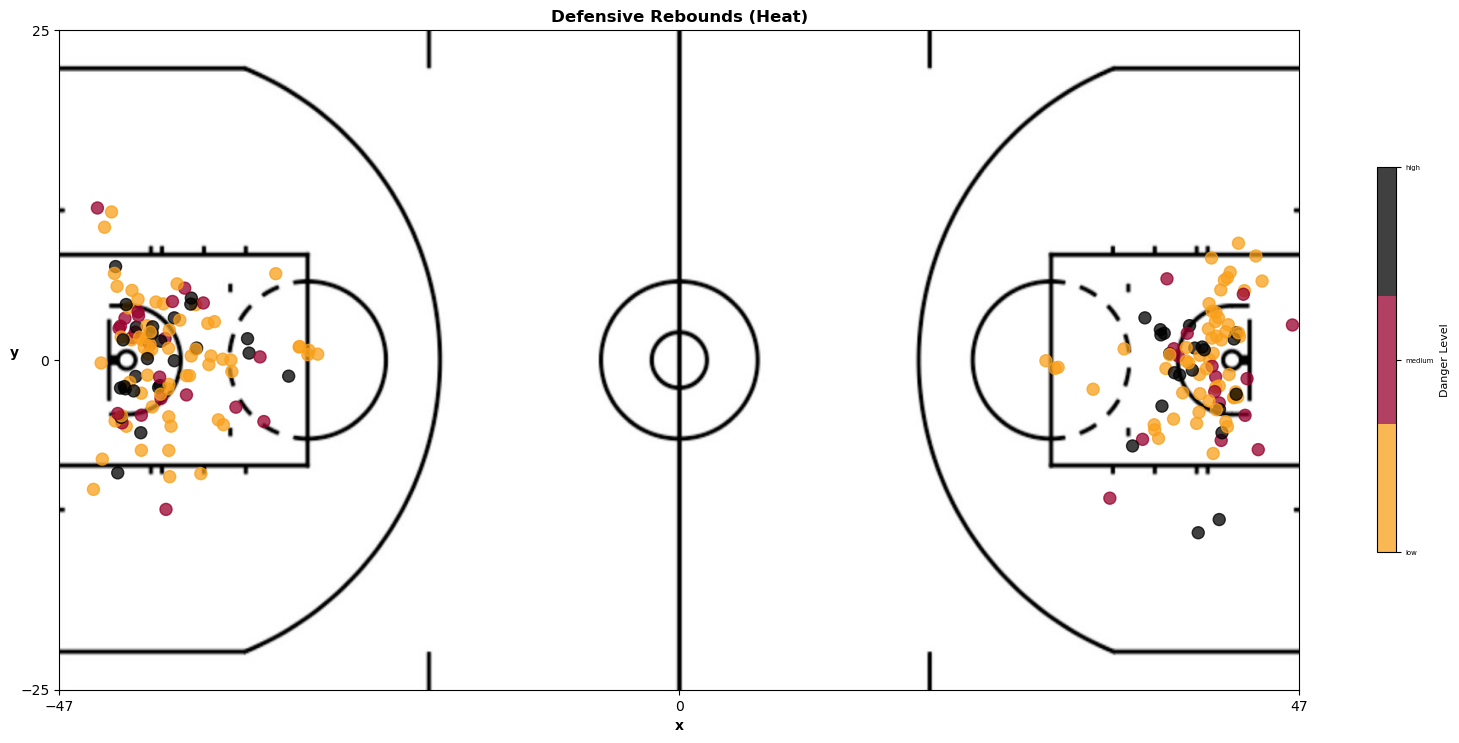

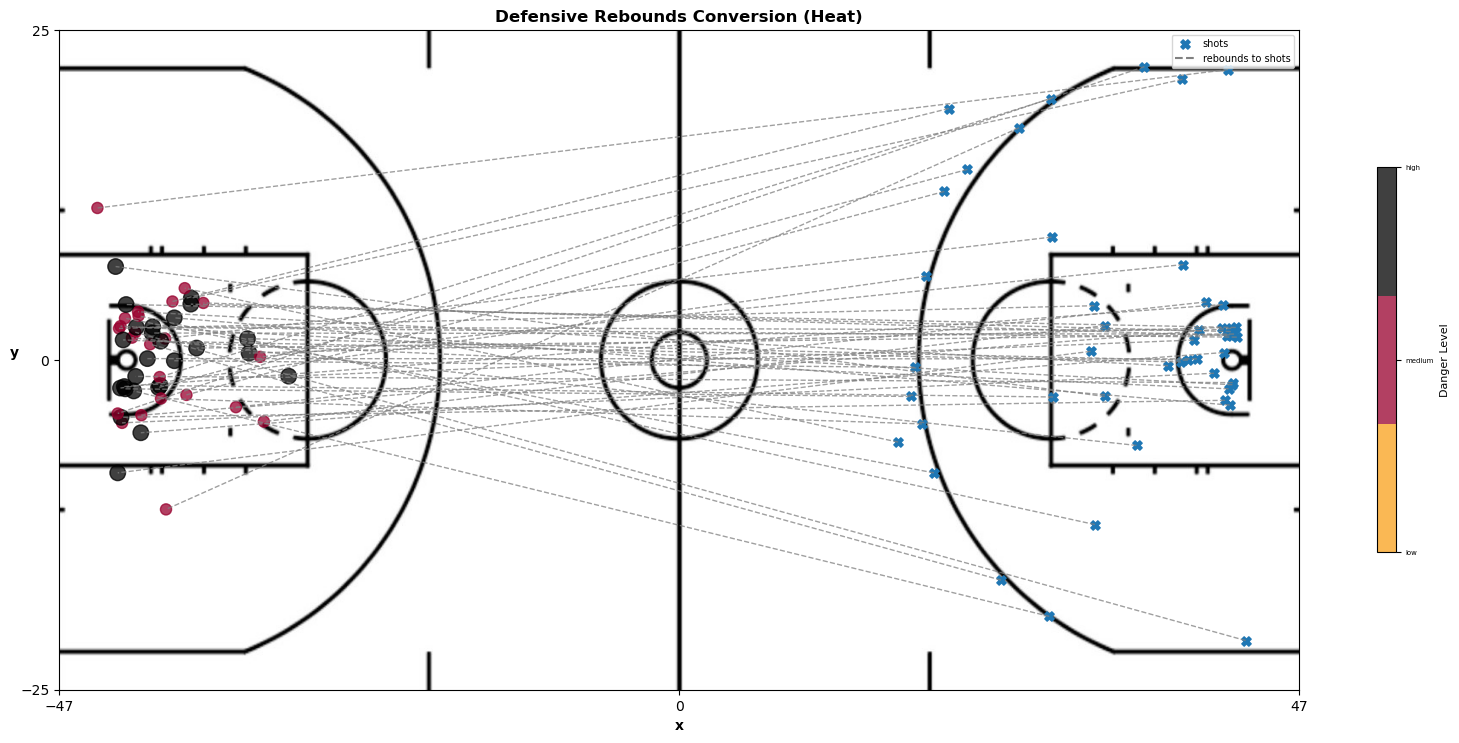

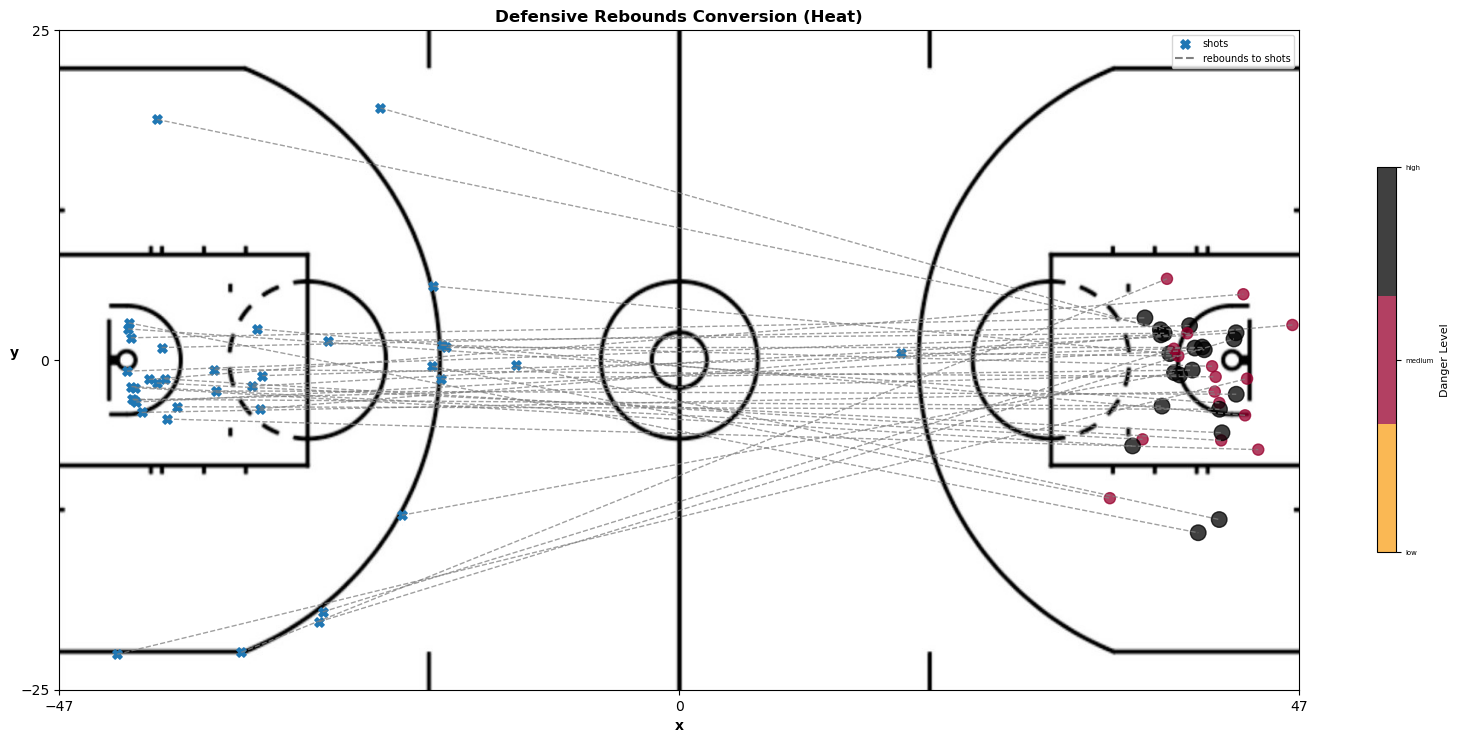

In [77]:
%%capture --no-display
## Heat Defensive Rebounds 
h_danger_df, h_danger_df_l, h_danger_df_r = get_dangers(game_ids[:7], 'Heat')
h_danger_l = h_danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
h_danger_r = h_danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(h_danger_df, 'Heat') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(h_danger_df_l, 'Heat') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(h_danger_df_r, 'Heat') # plot defensive rebound conversion right half
plt.show() # display the scatter plot

### Boston Celtics

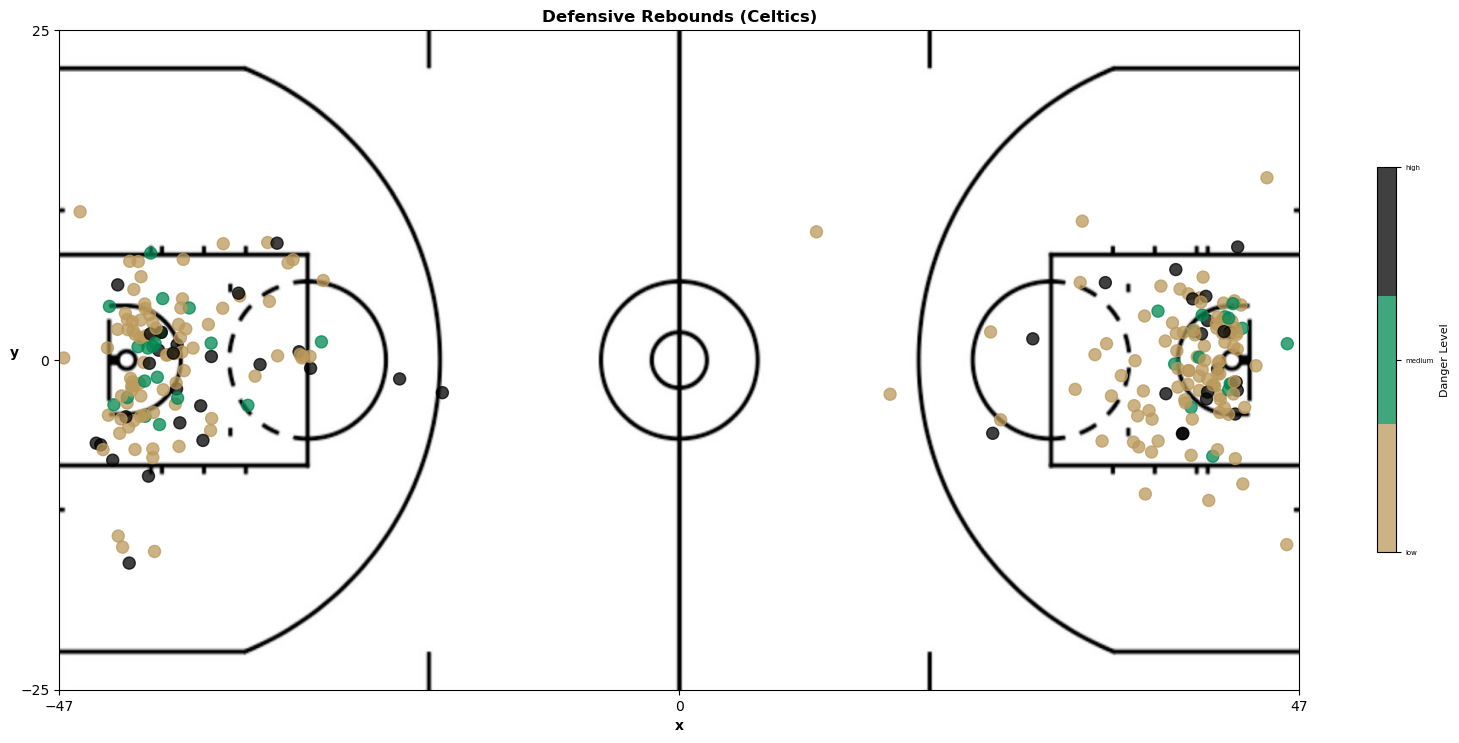

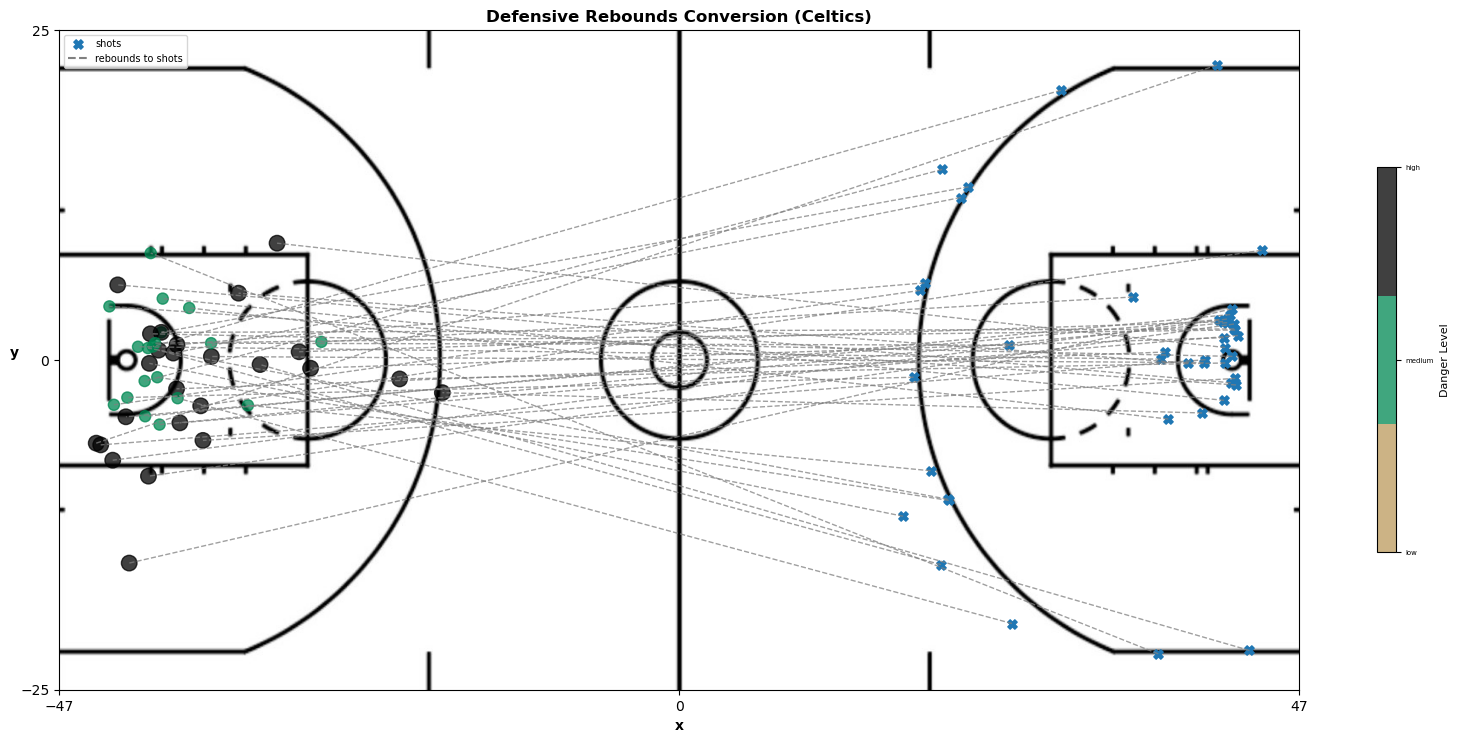

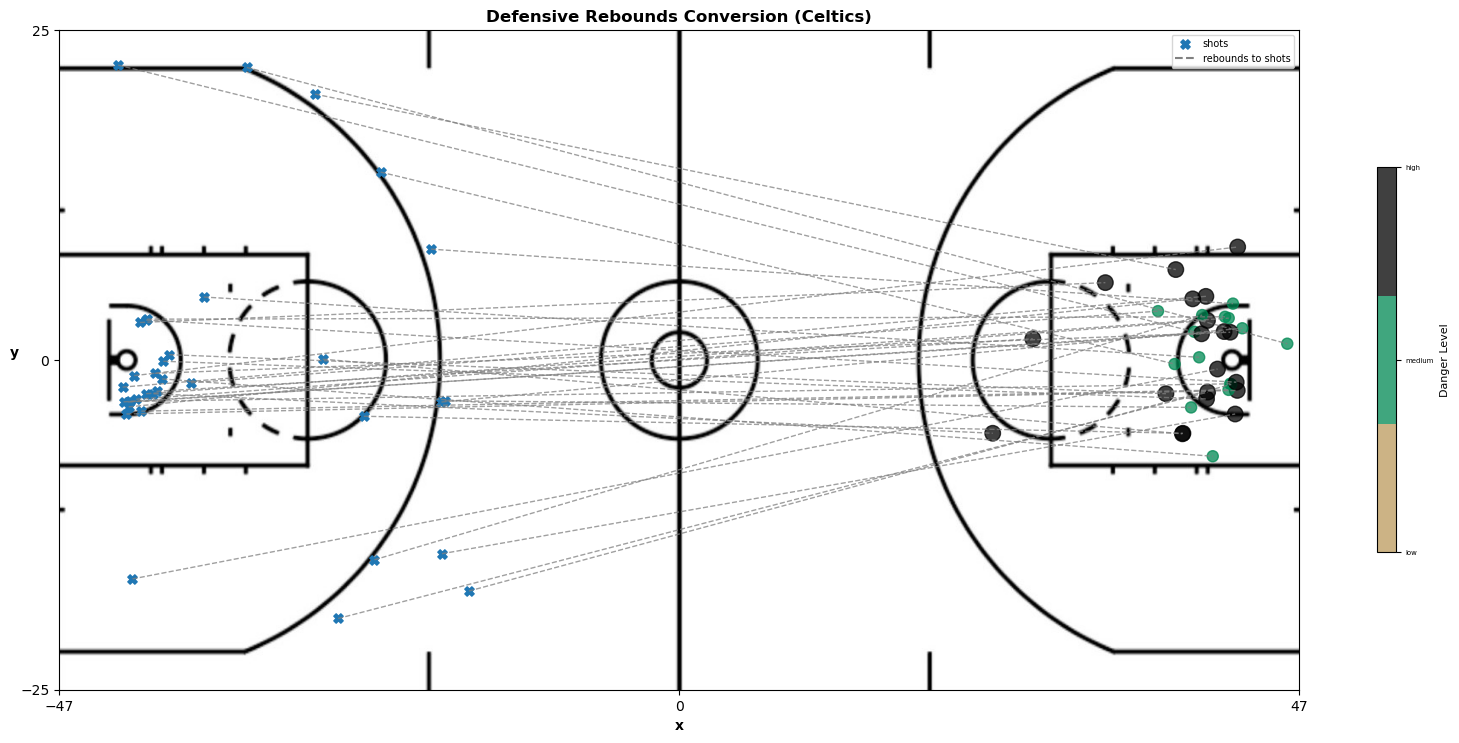

In [74]:
%%capture --no-display
## Boston Celtics Defensive Rebounds 
celt_danger_df, celt_danger_df_l, celt_danger_df_r = get_dangers(game_ids[:7], 'Celtics')
c_danger_l = celt_danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
c_danger_r = celt_danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(celt_danger_df, 'Celtics') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(celt_danger_df_l, 'Celtics') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(celt_danger_df_r, 'Celtics') # plot defensive rebound conversion right half
plt.show() # display the scatter plot

## Golden State Warriors vs. Dallas Mavericks
The following five games of the series. 

### Golden State Warriors

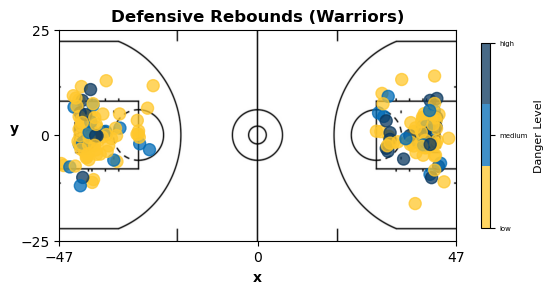

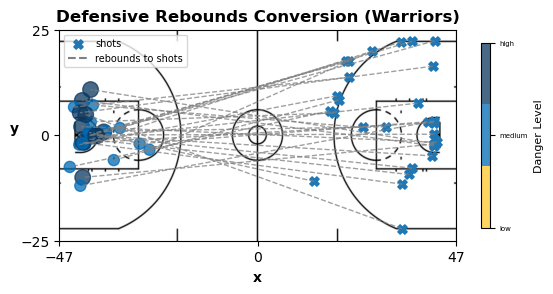

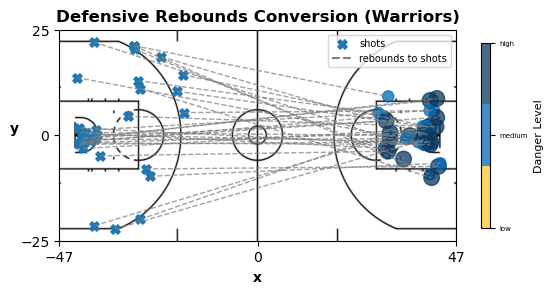

In [58]:
%%capture --no-display
## Golden State Defensive Rebounds 
war_danger_df, war_danger_df_l, war_danger_df_r = get_dangers(game_ids[7:12], 'Warriors')
w_danger_l = war_danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
w_danger_r = war_danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(war_danger_df, 'Warriors') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(war_danger_df_l, 'Warriors') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(war_danger_df_r, 'Warriors') # plot defensive rebound conversion right half
plt.show() # display the scatter plot

### Dallas Mavericks

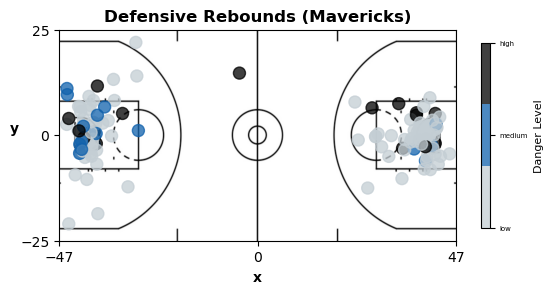

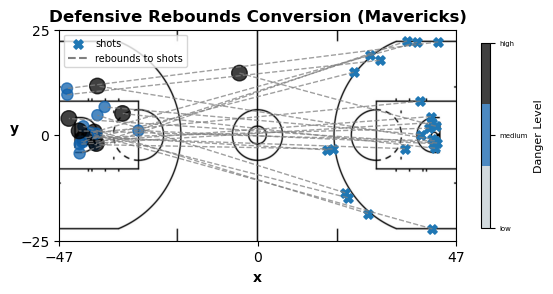

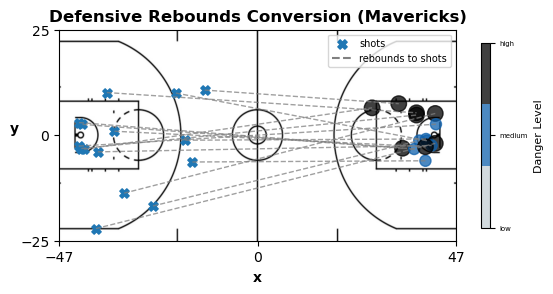

In [59]:
%%capture --no-display
## Dallas Mavericks Defensive Rebounds 
danger_df, danger_df_l, danger_df_r = get_dangers(game_ids[7:12], 'Mavericks')
danger_l = danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
danger_r = danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(danger_df, 'Mavericks') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(danger_df_l, 'Mavericks') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(danger_df_r, 'Mavericks') # plot defensive rebound conversion right half
plt.show() # display the scatter plot

## Golden State Warriors vs. Boston Celtics
The last six games of the series. 

### Golden State Warriors

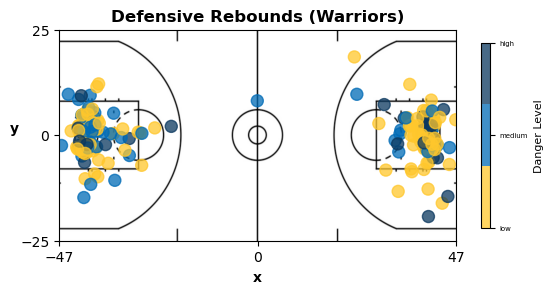

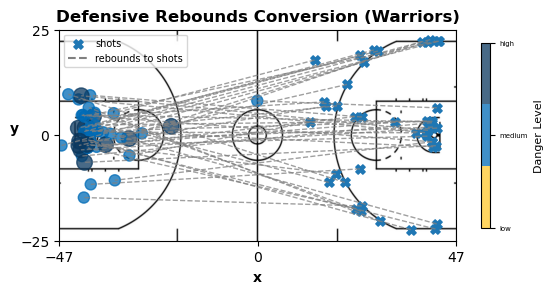

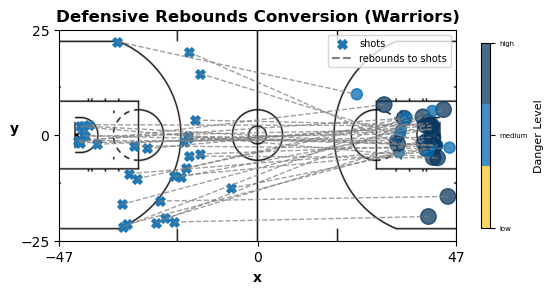

In [52]:
%%capture --no-display
## Warriors Second Game Defensive Rebounds
war2_danger_df, war2_danger_df_l, war2_danger_df_r = get_dangers(game_ids[12:18], 'Warriors')
w2_danger_l = war2_danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
w2_danger_r = war2_danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(war2_danger_df, 'Warriors') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(war2_danger_df_l, 'Warriors') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(war2_danger_df_r, 'Warriors') # plot defensive rebound conversion right half
plt.show() # display the scatter plot

### Boston Celtics

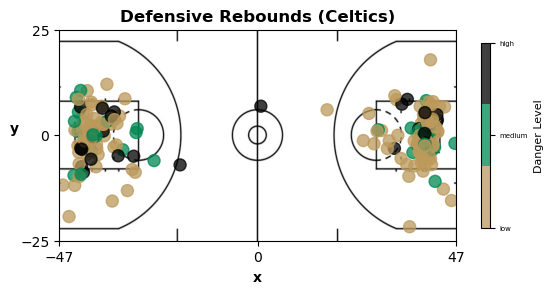

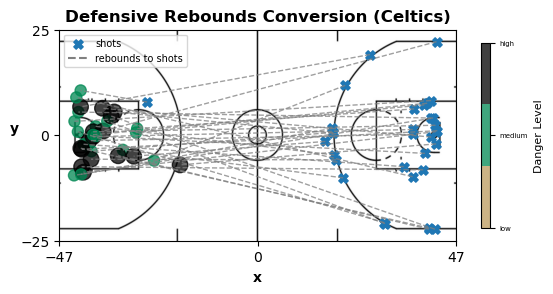

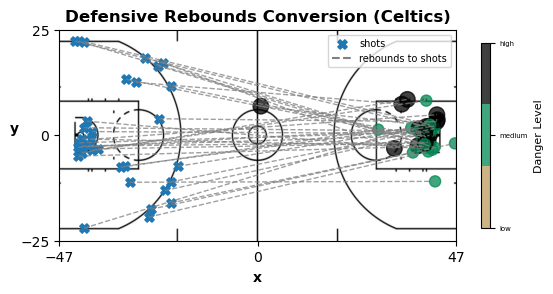

In [60]:
%%capture --no-display
## Celtics Second Game Defensive Rebounds
celt2_danger_df, celt2_danger_df_l, celt2_danger_df_r = get_dangers(game_ids[12:18], 'Celtics')
c2_danger_l = celt2_danger_df_l.dropna().filter(['danger'])['danger'].values.tolist()
c2_danger_r = celt2_danger_df_r.dropna().filter(['danger'])['danger'].values.tolist()

plot_init(celt2_danger_df, 'Celtics') # plot defensive rebounds
plt.show() # display the scatter plot

plot_conv_init(celt2_danger_df_l, 'Celtics') # plot defensive rebound conversion left half
plt.show() # display the scatter plot

plot_conv_init(celt2_danger_df_r, 'Celtics') # plot defensive rebound conversion right half
plt.show() # display the scatter plot